<a href="https://colab.research.google.com/github/ritikadhaker/Music-Genre-Classification/blob/main/Music_Genre_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

# Librosa (Library for audio analysis)
import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install kaggle

Download Kaggle API key from your Kaggle profile and upload the .json file here to run the following code and obtain GTZAN Dataset.

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

100% 1.21G/1.21G [00:12<00:00, 109MB/s]
100% 1.21G/1.21G [00:12<00:00, 107MB/s]


In [ ]:
!unzip /content/gtzan-dataset-music-genre-classification.zip

In [ ]:
import os
general_path = '/content/Data'
print(list(os.listdir(f'{general_path}/genres_original/')))

['reggae', 'classical', 'jazz', 'country', 'blues', 'rock', 'metal', 'hiphop', 'disco', 'pop']


Let's first Explore our Audio Data to see how it looks (we'll work with rock.00021.wav file).

Sound: sequence of vibrations in varying pressure strengths (y)

The sample rate (sr) is the number of samples of audio carried per second, measured in Hz or kHz

In [ ]:
# Importing 1 file
y, sr = librosa.load(f'{general_path}/genres_original/rock/rock.00021.wav')

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', sr, '\n')

# Verify length of the audio
print('Check Len of Audio:', 661794/22050)

y: [0.06521606 0.0954895  0.08926392 ... 0.10720825 0.20050049 0.1416626 ] 

y shape: (661794,) 

Sample Rate (KHz): 22050 

Check Len of Audio: 30.013333333333332


In [ ]:
# Trim leading and trailing silence from an audio signal (silence before and after the actual audio)
audio_file, _ = librosa.effects.trim(y)

# the result is an numpy ndarray
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))

Audio File: [0.06521606 0.0954895  0.08926392 ... 0.10720825 0.20050049 0.1416626 ] 

Audio File shape: (661794,)


## 2D Representation: Sound Waves

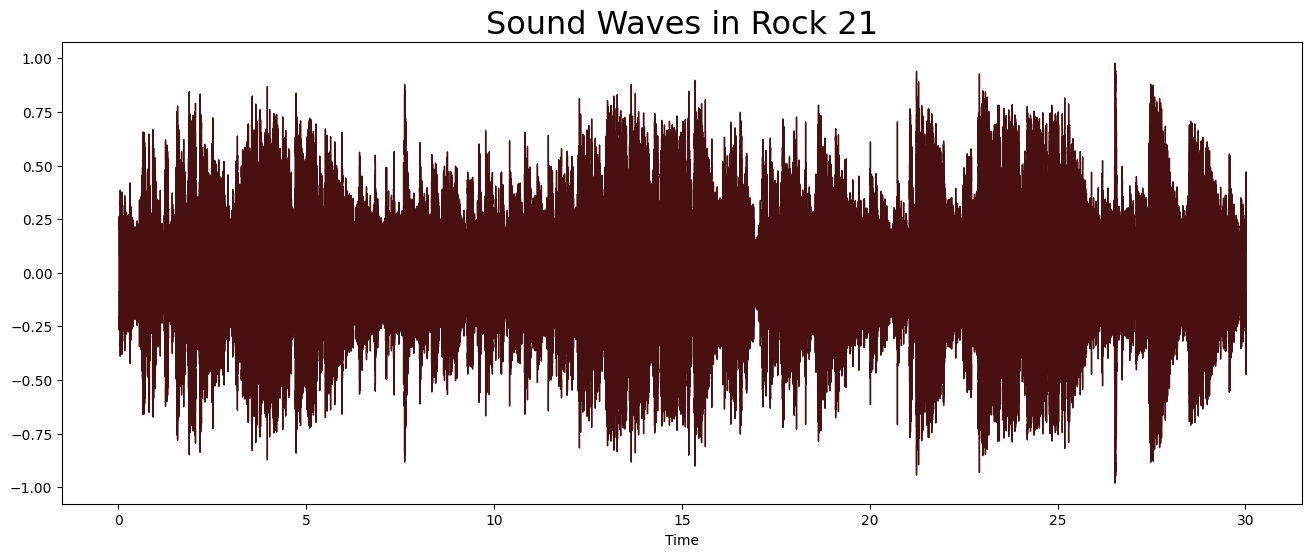

In [ ]:
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = audio_file, sr = sr, color = "#481011");
plt.title("Sound Waves in Rock 21", fontsize = 23);

## Fourier Transform

Function that gets a signal in the time domain as input, and outputs its decomposition into frequencies
Transform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is approx. the log scale of amplitudes.

In [ ]:
# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns

# Short-time Fourier transform (STFT)
D = np.abs(librosa.stft(audio_file, n_fft = n_fft, hop_length = hop_length))

print('Shape of D object:', np.shape(D))

Shape of D object: (1025, 1293)


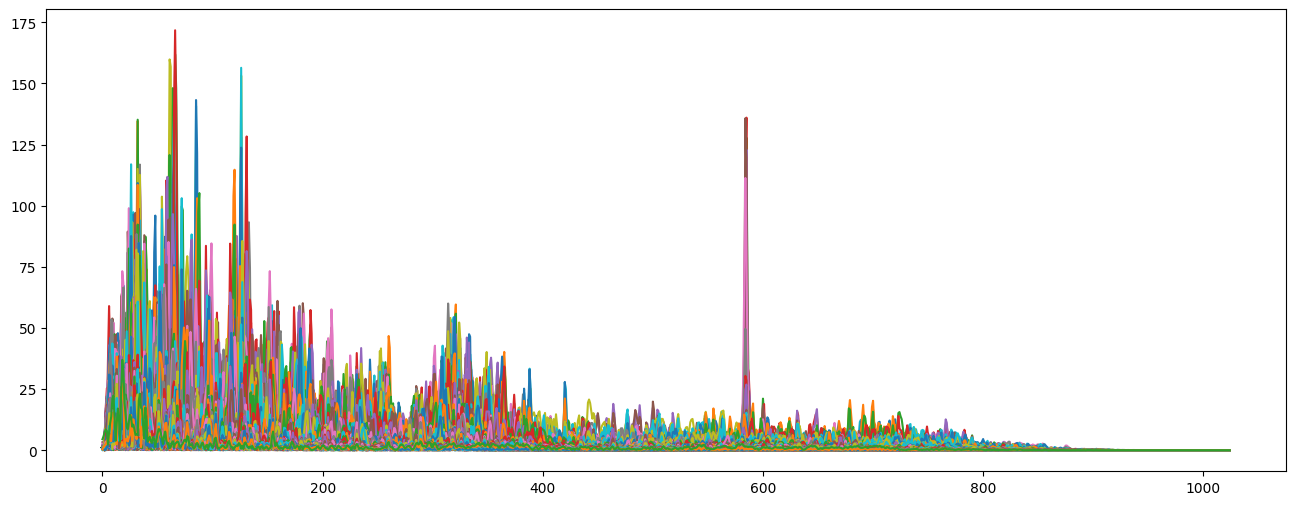

In [ ]:
plt.figure(figsize = (16, 6))
plt.plot(D);


## The Spectrogram

What is a spectrogram? A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time. When applied to an audio signal, spectrograms are sometimes called sonographs, voiceprints, or voicegrams.
Here we convert the frequency axis to a logarithmic one.

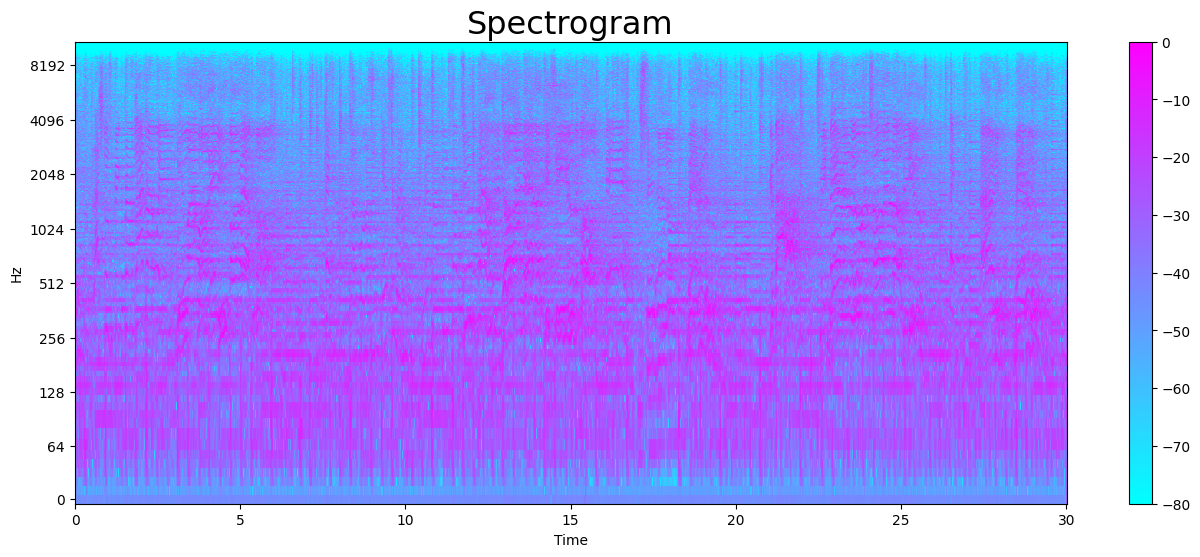

In [ ]:
# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
DB = librosa.amplitude_to_db(D, ref = np.max)

# Creating the Spectogram
plt.figure(figsize = (16, 6))
librosa.display.specshow(DB, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log', cmap = 'cool')
plt.colorbar();
plt.title("Spectrogram", fontsize = 23);

## Audio Features

###Zero Crossing Rate

the rate at which the signal changes from positive to negative or back.

In [ ]:
# Total zero_crossings in our 1 song
zero_crossings = librosa.zero_crossings(audio_file, pad=False)
print(sum(zero_crossings))

80556



###Harmonics and Percussion

Harmonics are characteristics that human ears can't distinguish (represents the sound color)

Percussion understanding shock wave represents the sound rhythm and emotion

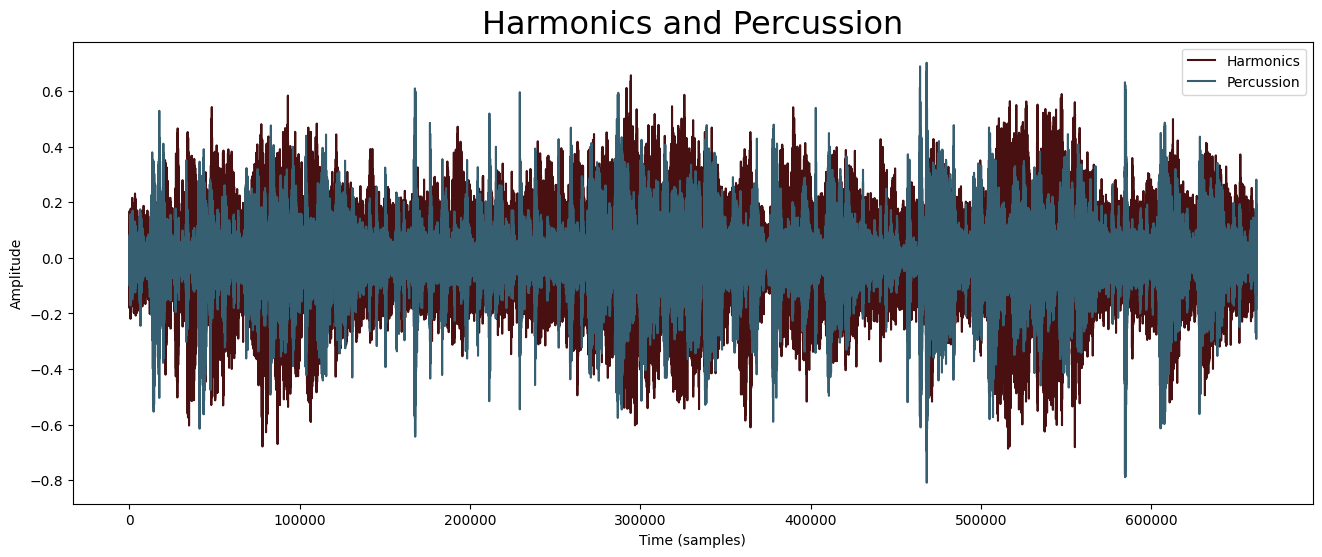

In [ ]:
y_harm, y_perc = librosa.effects.hpss(audio_file)

plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#481011', label='Harmonics');
plt.plot(y_perc, color = '#375f72', label='Percussion');
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
plt.title("Harmonics and Percussion", fontsize = 23);


###Tempo BPM (beats per minute)

Dynamic programming beat tracker.

In [ ]:
tempo, _ = librosa.beat.beat_track(y=y, sr = sr)
tempo

184.5703125

###Spectral Centroid

indicates where the ”centre of mass” for a sound is located and is calculated as the weighted mean of the frequencies present in the sound.

In [ ]:
# Calculate the Spectral Centroids
spectral_centroids = librosa.feature.spectral_centroid(y=audio_file, sr=sr)[0]

# Shape is a vector
print('Centroids:', spectral_centroids, '\n')
print('Shape of Spectral Centroids:', spectral_centroids.shape, '\n')

# Computing the time variable for visualization
frames = range(len(spectral_centroids))

# Converts frame counts to time (seconds)
t = librosa.frames_to_time(frames)

print('frames:', frames, '\n')
print('t:', t)

# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

Centroids: [1853.94773256 1791.2011266  1881.04902165 ... 1600.98394216 2024.86651587
 2486.9740011 ] 

Shape of Spectral Centroids: (1293,) 

frames: range(0, 1293) 

t: [0.00000000e+00 2.32199546e-02 4.64399093e-02 ... 2.99537415e+01
 2.99769615e+01 3.00001814e+01]


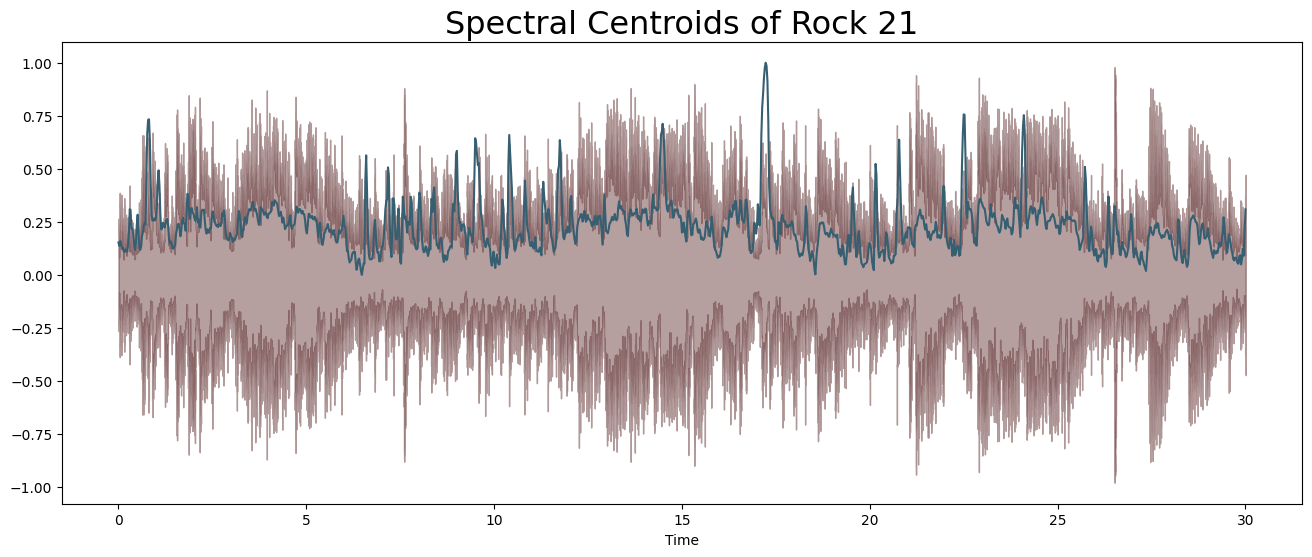

In [ ]:
#Plotting the Spectral Centroid along the waveform
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y=audio_file, sr=sr, alpha=0.4, color = '#481011');
plt.plot(t, normalize(spectral_centroids), color='#375f72');
plt.title("Spectral Centroids of Rock 21", fontsize = 23);

##Mel-Frequency Cepstral Coefficients:¶
The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. It models the characteristics of the human voice.

mfccs shape: (20, 1293)


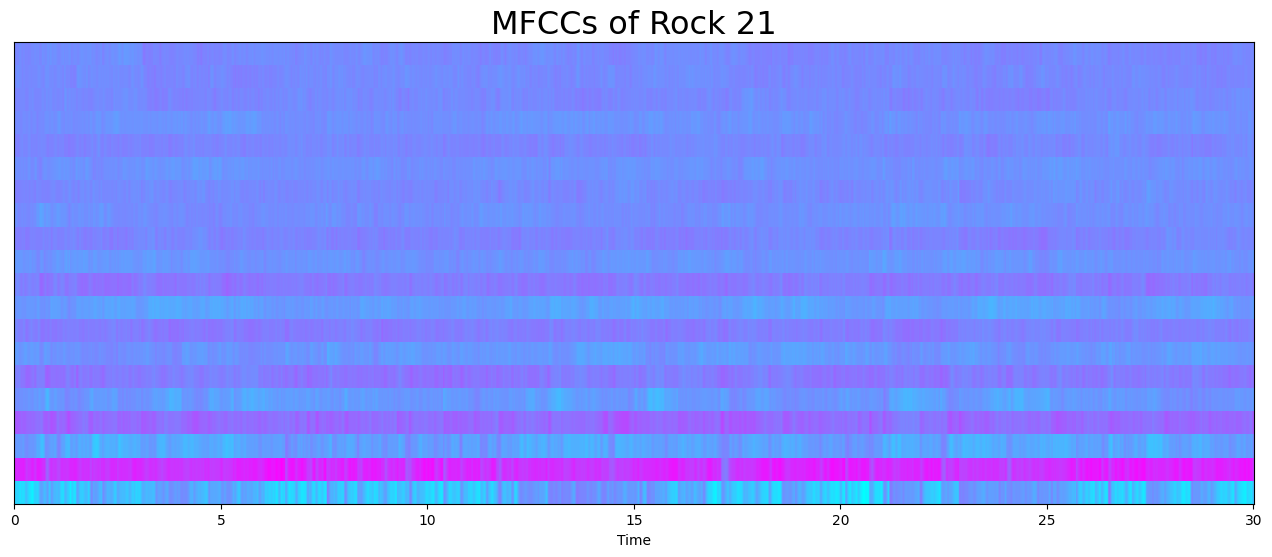

In [ ]:
mfccs = librosa.feature.mfcc(y=audio_file, sr=sr)
print('mfccs shape:', mfccs.shape)

#Displaying  the MFCCs:
plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cool');
plt.title("MFCCs of Rock 21", fontsize = 23);

###Chroma Frequencies

Chroma features are an interesting and powerful representation for music audio in which the entire spectrum is projected onto 12 bins representing the 12 distinct semitones (or chroma) of the musical octave.

Chromogram shape: (12, 133)


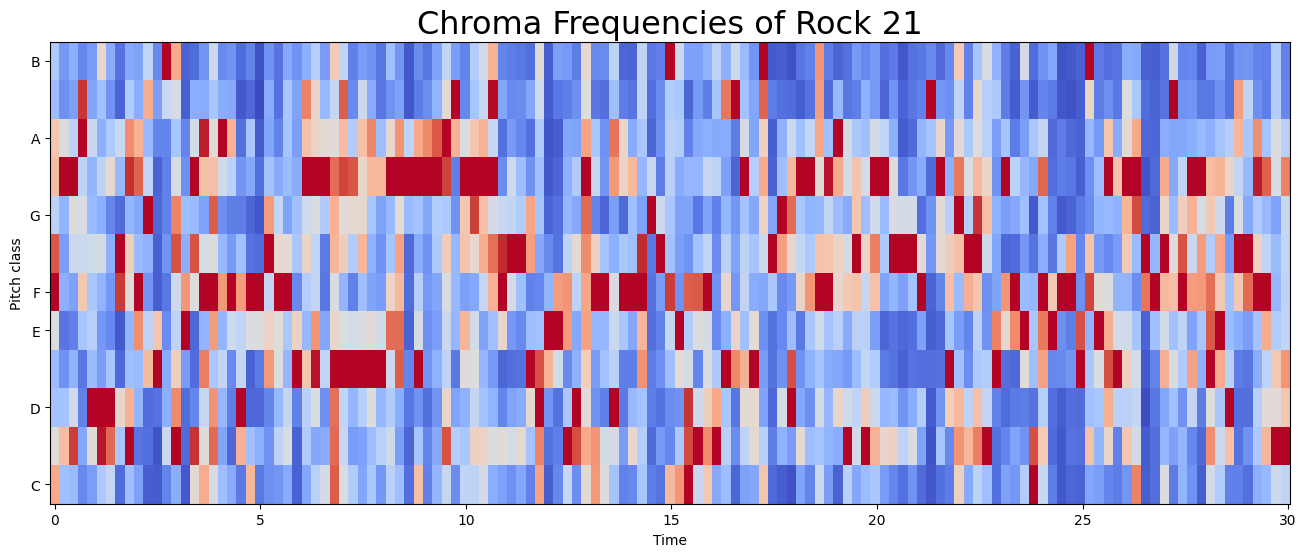

In [ ]:
# Increase or decrease hop_length to change how granular you want your data to be
hop_length = 5000

# Chromogram
chromagram = librosa.feature.chroma_stft(y=audio_file, sr=sr, hop_length=hop_length)
print('Chromogram shape:', chromagram.shape)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm');
plt.title("Chroma Frequencies of Rock 21", fontsize = 23);

#Exploratory Data Analysis

EDA is going to be performed on the features_30_sec.csv. This file contains the mean and variance for each audio file fo the features analysed above.

So, the table has a final of 1000 rows (10 genrex x 100 audio files) and 60 features (dimensionalities).

In [ ]:
data = pd.read_csv(f'{general_path}/features_30_sec.csv')
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


###Correlation Heatmap for feature means

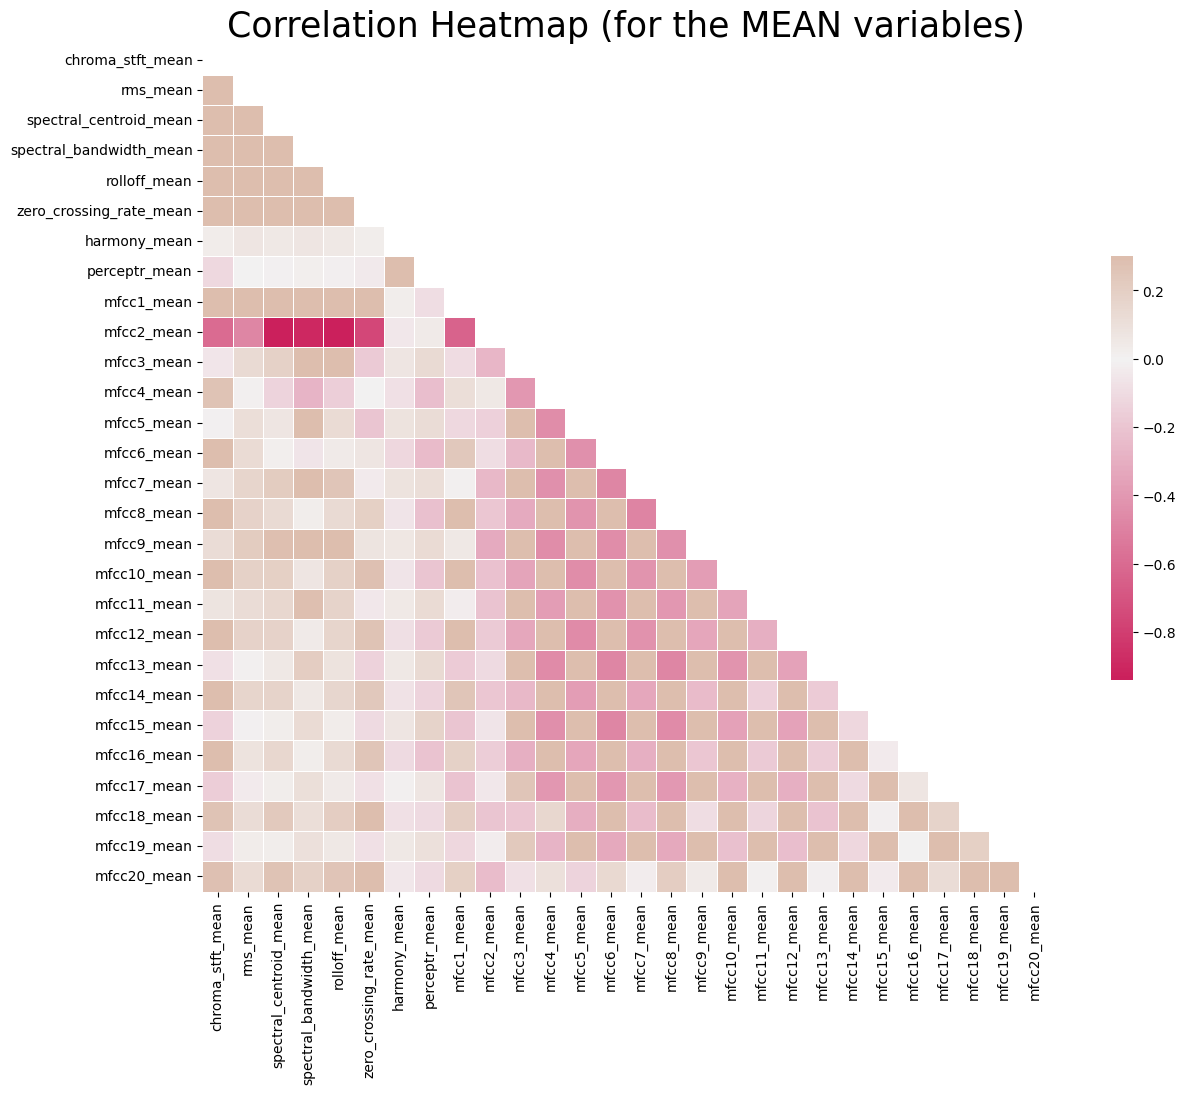

In [ ]:
# Computing the Correlation Matrix
spike_cols = [col for col in data.columns if 'mean' in col]
corr = data[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool_))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 25)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("Corr Heatmap.jpg")

###Box Plot for Genres Distributions

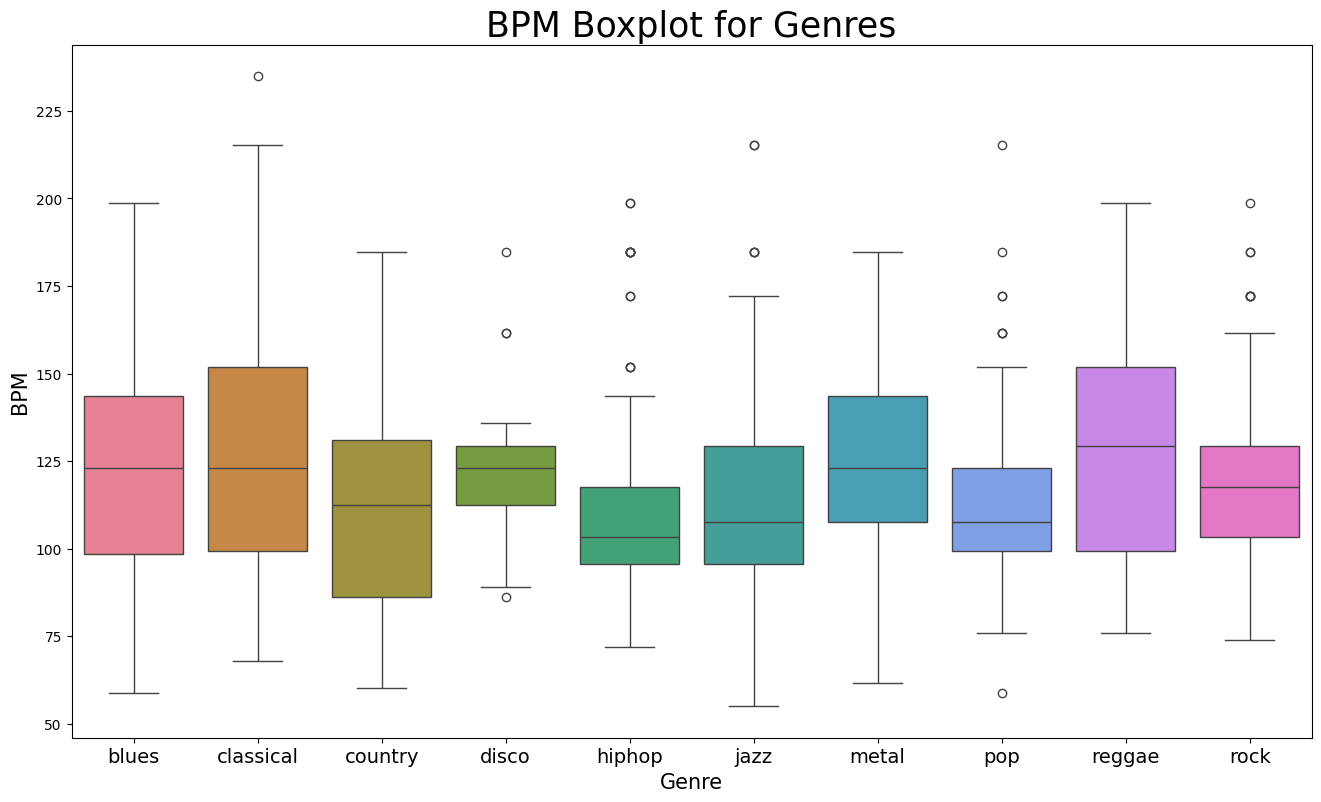

In [ ]:
x = data[["label", "tempo"]]

f, ax = plt.subplots(figsize=(16, 9));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM Boxplot.jpg")

##Principal Component Analysis - to visualize possible groups of genres

*   Normalization
*   PCA
*   The Scatter Plot



In [ ]:
from sklearn import preprocessing

data = data.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

#### NORMALIZE X ####
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)


#### PCA 2 COMPONENTS ####
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

pca.explained_variance_ratio_


array([0.2439355 , 0.21781804])

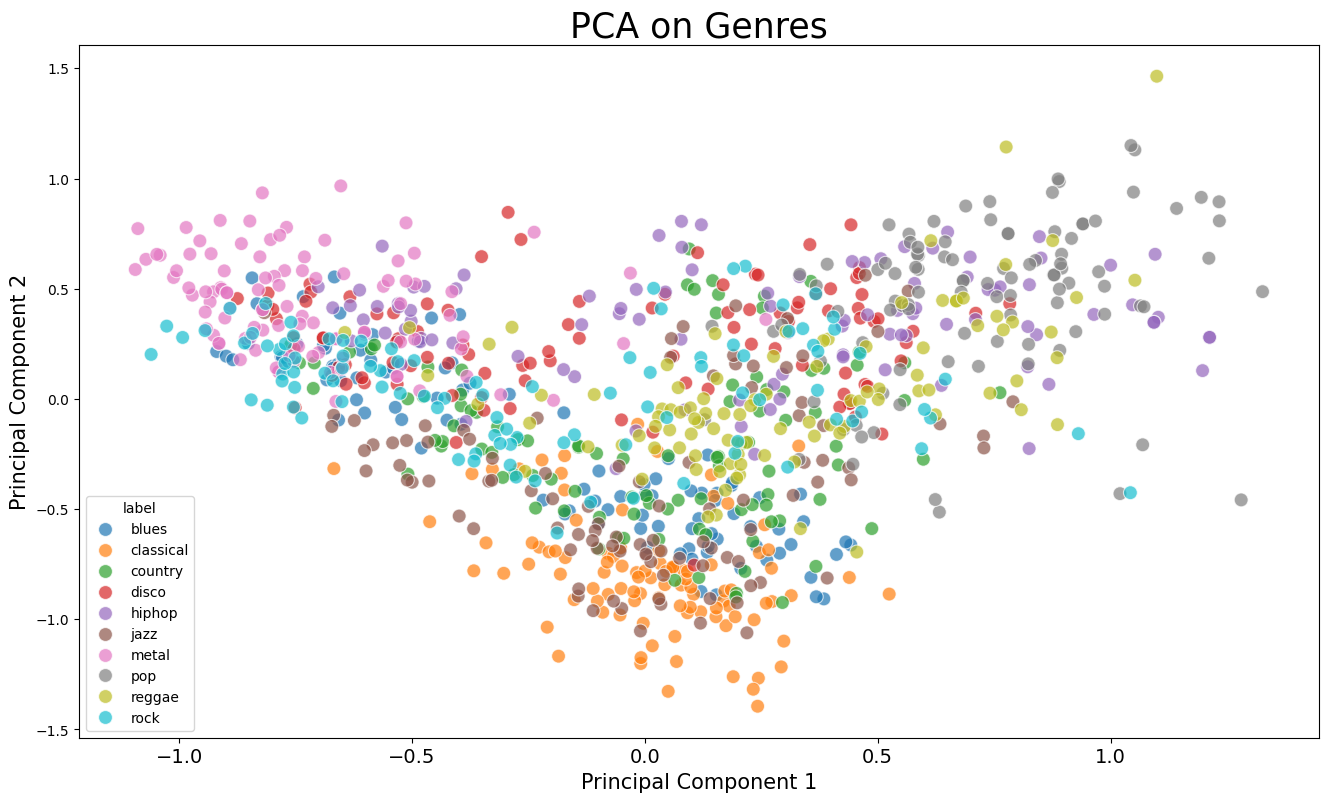

In [ ]:
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "principal component 1", y = "principal component 2", data = finalDf, hue = "label", alpha = 0.7,
               s = 100);

plt.title('PCA on Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA Scattert.jpg")

#Machine Learning Classification

In [ ]:
audio_dataset_path='/content/Data/genres_original'
metadata=pd.read_csv('/content/Data/features_30_sec.csv')
metadata.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


##Feature Extractor Function
Mel Frequency Cepstral Coefficients:

These are state-of-the art features used in automatic speech and speech recognition studies. There are a set of steps for generation of these features:

Since the audio signals are constantly changing, first we divide these signals into smaller frames. Each frame is around 20-40 ms long. Then we try to identify different frequencies present in each frame.
 Now, separate linguistic frequencies from the noise. To discard the noise, it then takes discrete cosine transform (DCT) of these frequencies. Using DCT we keep only a specific sequence of frequencies that have a high probability of information.

In [ ]:
def features_extractor(file):
  audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
  mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
  mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
  return mfccs_scaled_features

In [ ]:
#metadata.drop(labels=552, axis=0, inplace=True)

In [ ]:
from tqdm import tqdm
# Now we iterate through every audio file and extract features using Mel-Frequency Cepstral Coefficients

extracted_features=[]

for index_num, row in tqdm(metadata.iterrows()):
  try:
    final_class_labels=row["label"]
    file_name = os.path.join(os.path.abspath(audio_dataset_path), final_class_labels+'/',str(row["filename"]))
    data=features_extractor(file_name)
    extracted_features.append([data, final_class_labels])
  except Exception as e:
    print (f"Error: {e}")
    continue

558it [00:44, 10.86it/s]

Error: 


1000it [01:21, 12.24it/s]


In [ ]:
# converting extracted features to Pandas dataframe
extracted_features_df = pd.DataFrame(extracted_features, columns=[ 'feature', 'class'])
extracted_features_df.head()

,feature,class
0,"[-113.59882, 121.57067, -19.162262, 42.36394, ...",blues
1,"[-207.52383, 123.98514, 8.947019, 35.86715, 2....",blues
2,"[-90.757164, 140.44087, -29.084547, 31.686693,...",blues
3,"[-199.57513, 150.0861, 5.663404, 26.855282, 1....",blues
4,"[-160.35417, 126.20948, -35.581394, 22.139256,...",blues


In [ ]:
extracted_features_df['class'].value_counts()

class
blues        100
classical    100
country      100
disco        100
hiphop       100
metal        100
pop          100
reggae       100
rock         100
jazz          99
Name: count, dtype: int64

###Split the dataset into independent and dependent dataset

In [ ]:
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['class'].tolist())

In [ ]:
X.shape

(999, 40)

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [ ]:
y.shape

(999, 10)

### Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
X_train

array([[ 2.6653410e+01,  7.9789711e+01, -5.2055866e+01, ...,
        -1.4430333e+00, -1.2734197e+00, -5.9081397e+00],
       [-1.4495711e+02,  1.1846496e+02,  2.0525068e+01, ...,
         1.8998557e+00, -1.8821739e+00, -1.8517891e+00],
       [-6.6108925e+01,  9.7883812e+01, -1.8831675e+01, ...,
        -1.2424636e+00, -6.3691199e-01, -1.3383397e+00],
       ...,
       [-7.7426697e+01,  1.3087869e+02, -2.3275221e+01, ...,
        -4.2062173e+00, -3.5183537e+00,  2.6050329e+00],
       [-1.9040649e+02,  1.2951292e+02, -7.8296256e+00, ...,
        -2.2419319e+00, -3.9879441e+00, -1.9877437e+00],
       [-4.6609550e+01,  8.6802010e+01, -3.4776669e+01, ...,
         1.4675997e-01,  9.2151546e-01, -8.7239462e-01]], dtype=float32)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(799, 40)
(200, 40)
(799, 10)
(200, 10)


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [ ]:
# Number of categories
num_labels=y.shape[1]
print(num_labels)

10


In [ ]:
model=Sequential()

model.add(Dense(1024, input_shape=(40,), activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(64, activation="relu") )
model.add(Dropout(0.3))
model.add(Dense(32, activation="relu") )
model.add(Dropout(0.3))

#final layer
model.add(Dense(num_labels, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              41984     
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               3

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
num_epochs = 100
num_batch_size = 32

history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
25/25 [==============================] - 3s 49ms/step - loss: 5.2476 - accuracy: 0.0889 - val_loss: 2.3197 - val_accuracy: 0.0550
Epoch 2/100
25/25 [==============================] - 1s 23ms/step - loss: 2.7517 - accuracy: 0.1202 - val_loss: 2.2812 - val_accuracy: 0.1600
Epoch 3/100
25/25 [==============================] - 1s 20ms/step - loss: 2.3963 - accuracy: 0.1302 - val_loss: 2.2745 - val_accuracy: 0.1350
Epoch 4/100
25/25 [==============================] - 1s 23ms/step - loss: 2.3320 - accuracy: 0.1202 - val_loss: 2.2534 - val_accuracy: 0.1550
Epoch 5/100
25/25 [==============================] - 1s 20ms/step - loss: 2.3393 - accuracy: 0.1227 - val_loss: 2.2376 - val_accuracy: 0.1800
Epoch 6/100
25/25 [==============================] - 1s 21ms/step - loss: 2.2829 - accuracy: 0.1427 - val_loss: 2.2123 - val_accuracy: 0.1800
Epoch 7/100
25/25 [==============================] - 1s 21ms/step - loss: 2.2326 - accuracy: 0.1602 - val_loss: 2.1642 - val_accuracy: 0.1700
Epoch 

In [ ]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

7/7 [==============================] - 0s 4ms/step - loss: 1.5764 - accuracy: 0.5850
Test accuracy: 0.5849999785423279


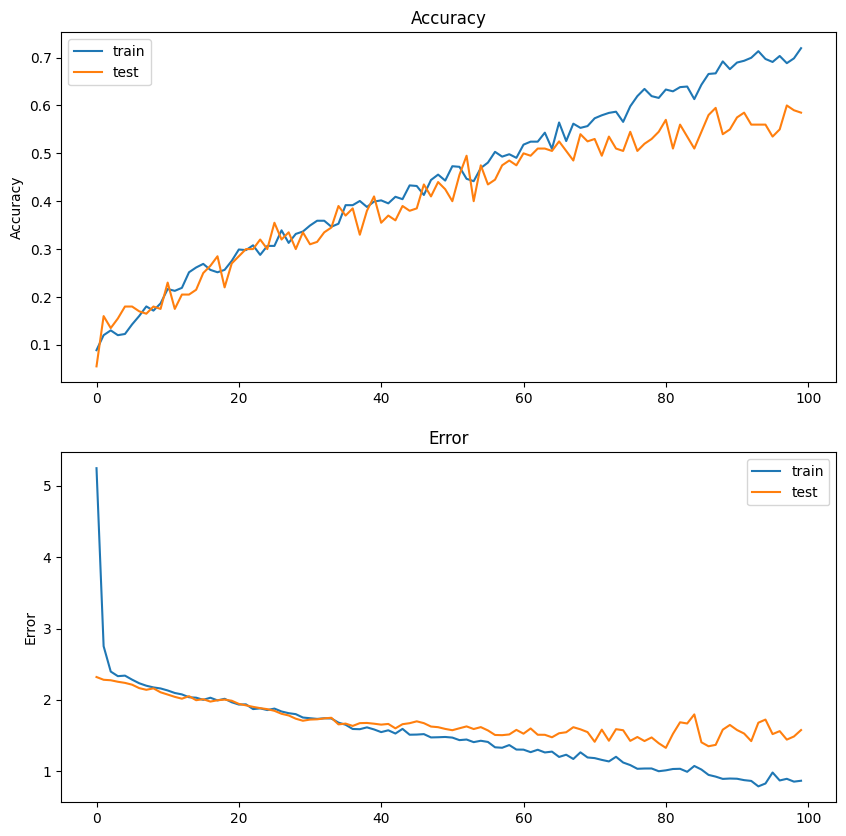

In [ ]:
fig, axs = plt.subplots(2,figsize=(10,10))

# accuracy
axs[0].plot(history.history["accuracy"], label="train")
axs[0].plot(history.history["val_accuracy"], label="test")
axs[0].set_ylabel("Accuracy")
axs[0].legend()
axs[0].set_title("Accuracy")

# Error
axs[1].plot(history.history["loss"], label="train")
axs[1].plot(history.history["val_loss"], label="test")
axs[1].set_ylabel("Error")
axs[1].legend()
axs[1].set_title("Error")

plt.show()

In [ ]:
predictions = model.predict(X_test)

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

7/7 [==============================] - 0s 4ms/step


In [ ]:
filename="/content/Data/genres_original/pop/pop.00032.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

# Reshape the feature vector to match expected input shape for prediction
mfccs_scaled_features = mfccs_scaled_features.reshape(1, -1)

# Predict using the model
predicted_probabilities = model.predict(mfccs_scaled_features)

# Get the index of the class with the highest probability
predicted_label_index = np.argmax(predicted_probabilities)


# Inverse transform the predicted label index to get the class name
predicted_class = labelencoder.inverse_transform([predicted_label_index])[0]

# Print the predicted class
print("Predicted Class:", predicted_class)

1/1 [==============================] - 0s 35ms/step
Predicted Class: pop


 # Neural Network 2

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

model = Sequential()

model.add(Flatten(input_shape=(40,)))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 40)                0         
                                                                 
 dense_7 (Dense)             (None, 256)               10496     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                1290      
                                                      

In [ ]:
adam = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=adam,
             loss="categorical_crossentropy",
             metrics=["accuracy"])

history = model.fit(X_train, y_train,
                    epochs = 100,
                    batch_size = 32,
                    validation_data = (X_test,y_test),
                    verbose=1)

Epoch 1/100
25/25 [==============================] - 2s 14ms/step - loss: 2.5322 - accuracy: 0.1727 - val_loss: 3.4088 - val_accuracy: 0.1700
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 2.1980 - accuracy: 0.2503 - val_loss: 2.4209 - val_accuracy: 0.2550
Epoch 3/100
25/25 [==============================] - 0s 7ms/step - loss: 2.0377 - accuracy: 0.2766 - val_loss: 2.1453 - val_accuracy: 0.2900
Epoch 4/100
25/25 [==============================] - 0s 5ms/step - loss: 1.8971 - accuracy: 0.3467 - val_loss: 2.0131 - val_accuracy: 0.3050
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 1.8142 - accuracy: 0.3630 - val_loss: 1.8962 - val_accuracy: 0.3250
Epoch 6/100
25/25 [==============================] - 0s 5ms/step - loss: 1.7373 - accuracy: 0.4243 - val_loss: 1.8205 - val_accuracy: 0.3850
Epoch 7/100
25/25 [==============================] - 0s 6ms/step - loss: 1.7156 - accuracy: 0.4105 - val_loss: 1.7531 - val_accuracy: 0.4000
Epoch 8/100


In [ ]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

7/7 [==============================] - 0s 3ms/step - loss: 0.9931 - accuracy: 0.6200
Test accuracy: 0.6200000047683716


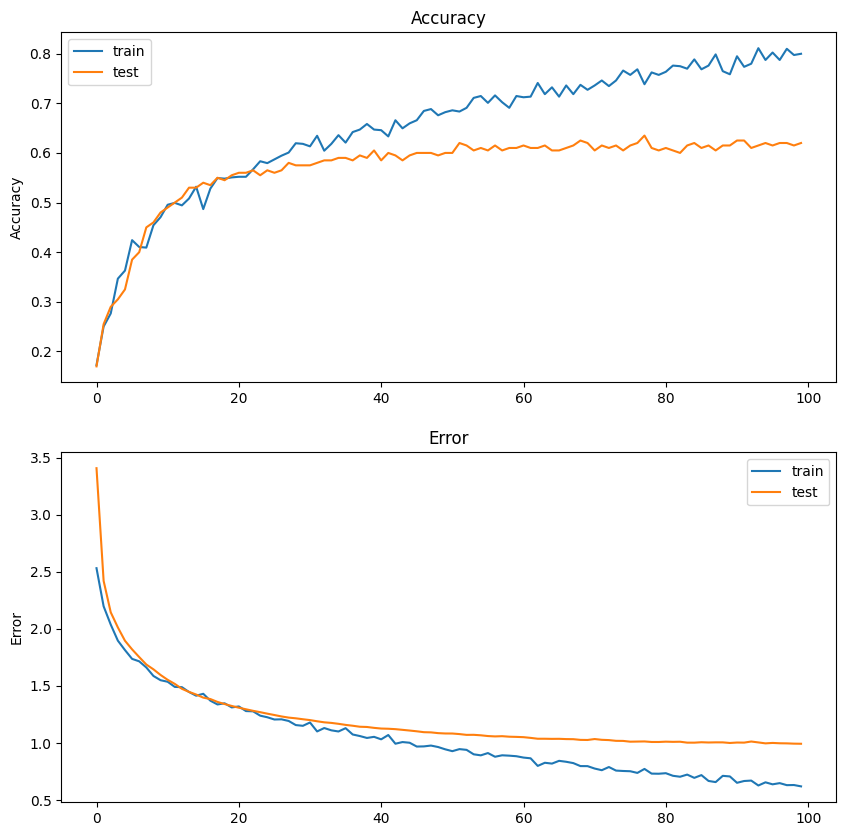

In [ ]:
fig, axs = plt.subplots(2,figsize=(10,10))

# accuracy
axs[0].plot(history.history["accuracy"], label="train")
axs[0].plot(history.history["val_accuracy"], label="test")
axs[0].set_ylabel("Accuracy")
axs[0].legend()
axs[0].set_title("Accuracy")

# Error
axs[1].plot(history.history["loss"], label="train")
axs[1].plot(history.history["val_loss"], label="test")
axs[1].set_ylabel("Error")
axs[1].legend()
axs[1].set_title("Error")

plt.show()

In [ ]:
filename="/content/Data/genres_original/jazz/jazz.00032.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

# Reshape the feature vector to match expected input shape for prediction
mfccs_scaled_features = mfccs_scaled_features.reshape(1, -1)

# Predict using the model
predicted_probabilities = model.predict(mfccs_scaled_features)

# Get the index of the class with the highest probability
predicted_label_index = np.argmax(predicted_probabilities)

# Inverse transform the predicted label index to get the class name
predicted_class = labelencoder.inverse_transform([predicted_label_index])[0]

# Print the predicted class
print("Predicted Class:", predicted_class)

1/1 [==============================] - 0s 34ms/step
Predicted Class: jazz


##Cross Gradient Booster Model

In [ ]:
from xgboost import XGBClassifier, XGBRFClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

In [ ]:
data = pd.read_csv(f'{general_path}/features_3_sec.csv')
data = data.iloc[0:, 1:]
data.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
y = data['label'] # genre variable.
X = data.loc[:, data.columns != 'label'] #select all columns but not the labels

#### NORMALIZE X ####

# Normalize so everything is on the same scale.

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# new data frame with the new scaled data.
X = pd.DataFrame(np_scaled, columns = cols)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Accuracy : 0.9009 



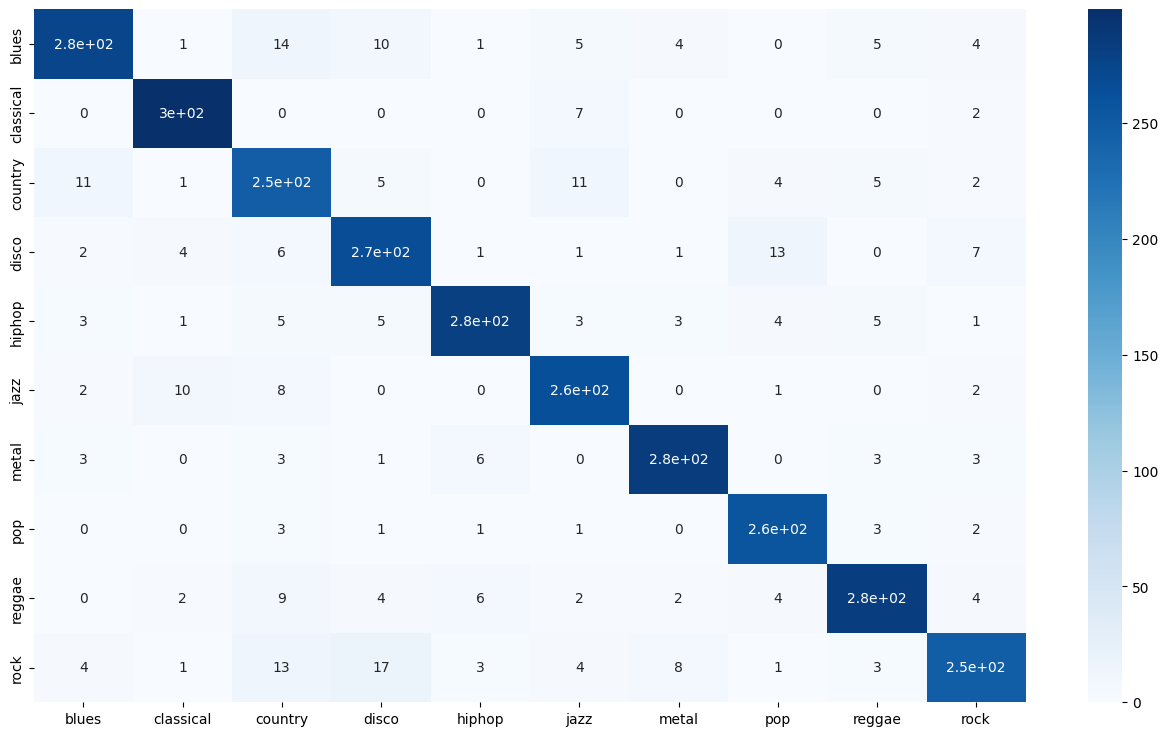

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the target labels (y_train)
y_train_encoded = label_encoder.fit_transform(y_train)

# Transform the target labels (y_test)
y_test_encoded = label_encoder.transform(y_test)

# Final model
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb.fit(X_train, y_train_encoded)


preds = xgb.predict(X_test)

print('Accuracy', ':', round(accuracy_score(y_test_encoded, preds), 5), '\n')

# Confusion Matrix
confusion_matr = confusion_matrix(y_test_encoded, preds) #normalize = 'true'
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True,
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);
plt.savefig("conf matrix")